# Demand forecasting

Demand forecasting is the process of predicting what the demand for certain products will be in the future. This helps manufacturers to decide what they should produce and guides retailers toward what they should stock.

## Importing essential libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

import statsmodels.api as sm
get_ipython().run_line_magic('matplotlib', 'inline')

## Dataset is opened using pandas

In [2]:
dataset = pd.read_excel('Superstore.xls')
dataset.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
dataset.dtypes

Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object

In [4]:
dataset.shape

(9994, 21)

In [5]:
dataset.corr()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
Row ID,1.000000,0.009671,-0.001359,-0.004016,0.013480,0.012497
Postal Code,0.009671,1.000000,-0.023854,0.012761,0.058443,-0.029961
Sales,-0.001359,-0.023854,1.000000,0.200795,-0.028190,0.479064
Quantity,-0.004016,0.012761,0.200795,1.000000,0.008623,0.066253
Discount,0.013480,0.058443,-0.028190,0.008623,1.000000,-0.219487
Profit,0.012497,-0.029961,0.479064,0.066253,-0.219487,1.000000


In [6]:
corr = dataset[['Quantity','Profit','Sales']].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,Quantity,Profit,Sales
Quantity,1.000,0.066,0.201
Profit,0.066,1.000,0.479
Sales,0.201,0.479,1.000


## Relation between Profit and Sales depicted in a Scatter graph

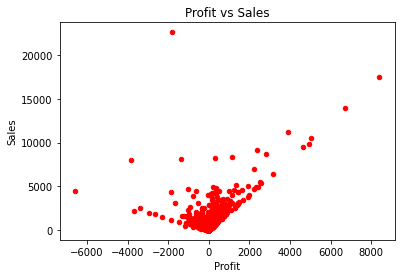

In [7]:
dataset.plot.scatter(x='Profit', y='Sales',c='red', title='Profit vs Sales')
plt.show()

## Finding which are the types of products that they uses to sell

In [8]:
set(dataset['Category'])

{'Furniture', 'Office Supplies', 'Technology'}

## Data Preprocessing

## We will first analyse the time series of Furniture Sales followed by other categories.

In [9]:
furniture = dataset.loc[dataset['Category'] == 'Furniture']

print(furniture['Order Date'].min())
furniture['Order Date'].max()

2014-01-06 00:00:00


Timestamp('2017-12-30 00:00:00')

This shows that we have time-series data of 4 years for furniture sales.

Here we drops the unwanted columns of furiture sales

In [10]:
furniture=furniture.drop(columns=['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City',
        'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity',
        'Discount', 'Profit'])

In [11]:
furniture

,Order Date,Sales
0,2016-11-08,261.9600
1,2016-11-08,731.9400
3,2015-10-11,957.5775
5,2014-06-09,48.8600
10,2014-06-09,1706.1840
...,...,...
9962,2015-03-19,383.4656
9964,2016-12-05,13.4000
9980,2015-09-06,85.9800
9989,2014-01-21,25.2480


In [12]:
furniture.sort_values('Order Date')
furniture.isna().sum()

Order Date    0
Sales         0
dtype: int64

In [13]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

# ## Indexing time-series data 

In [14]:
furniture = furniture.set_index('Order Date')
#furniture = furniture.apply(lambda x: x.set_index('Order Date'))
furniture.index


DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

## Averaging Daily Sales

In [15]:
y = furniture['Sales'].resample('MS').mean()
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

## Furniture data time-series visualization

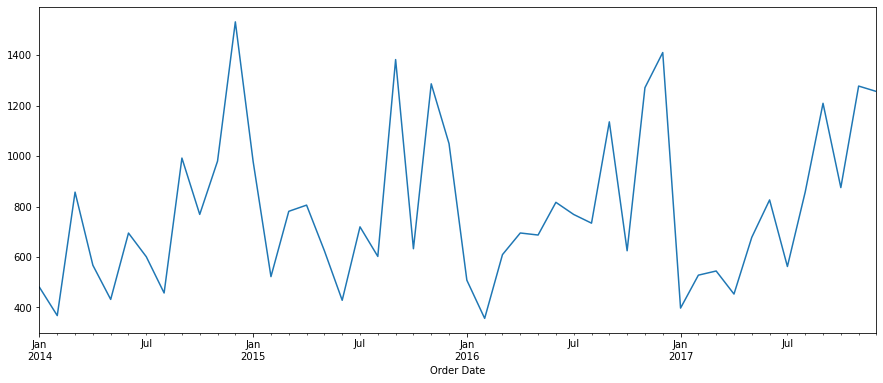

In [16]:
y.plot(figsize=(15, 6))
plt.show()

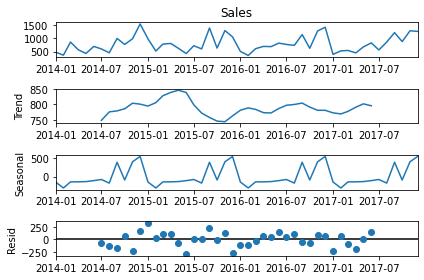

In [17]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot()
plt.show()

The above plot shows that the sales of furniture is highly unstable with seasonality and trend easily observable.

## Time Series forecasting with ARIMA Model


In [18]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

print('Few parameter combinations are:')
print('{} x {}'.format(pdq[1], seasonal_pdq[1]))
print('{} x {}'.format(pdq[2], seasonal_pdq[2]))

Few parameter combinations are:
(0, 0, 1) x (0, 0, 1, 12)
(0, 1, 0) x (0, 1, 0, 12)


 Now that we've generated all possible parameters for our SARIMA model, we shall find out the best parameter to train the model on it finally. :)
 
**SARIMA** stands for **Seasonal AutoRegressive Integrated Moving Average** model which is an extension of ARIMA model used in modeling the seasonality component as well. So, we need not to make time-series stationary (non-seasonal) first before forecasting. 


In [19]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=param_seasonal, enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = model.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
            

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:769.0817523205915


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1433.3633359529954
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:477.71701309202774
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:302.2702899793577
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:497.23144334183365


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:1375.4122865465915
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:304.24882803020546
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:720.9252270758102


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:2757.900423002575
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:466.56074298091625
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:291.62613896732984


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:499.5835309291343


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:2487.3475128402724
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:319.9884876946869


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:291.872557643182
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:677.894766859465


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1204.785150980287
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:486.63785671879367
ARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC:304.9671228167961
ARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:497.78896630044073


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(1, 0, 1, 12) - AIC:1582.5089810658903
ARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC:319.7714068109211
ARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC:306.9113200151402
ARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC:649.9056176816908
ARIMA(0, 1, 1)x(0, 0, 1, 12) - AIC:2055.41920630782
ARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC:458.8705548482811


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC:279.5806233365374
ARIMA(0, 1, 1)x(1, 0, 0, 12) - AIC:486.18329774427104
ARIMA(0, 1, 1)x(1, 0, 1, 12) - AIC:2581.0605977492287
ARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC:310.757436841732


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:281.55766214612476
ARIMA(1, 0, 0)x(0, 0, 0, 12) - AIC:692.1645522067712
ARIMA(1, 0, 0)x(0, 0, 1, 12) - AIC:1522.1191172391368
ARIMA(1, 0, 0)x(0, 1, 0, 12) - AIC:479.46321478521355


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 0)x(0, 1, 1, 12) - AIC:304.2077675160945
ARIMA(1, 0, 0)x(1, 0, 0, 12) - AIC:480.92593679351955


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(1, 0, 1, 12) - AIC:1551.0329320441315
ARIMA(1, 0, 0)x(1, 1, 0, 12) - AIC:304.46646750846014


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 0)x(1, 1, 1, 12) - AIC:304.5842692143804
ARIMA(1, 0, 1)x(0, 0, 0, 12) - AIC:665.7794442184892
ARIMA(1, 0, 1)x(0, 0, 1, 12) - AIC:2701.258645266984
ARIMA(1, 0, 1)x(0, 1, 0, 12) - AIC:468.3685195815049


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 1)x(0, 1, 1, 12) - AIC:293.3422193965913
ARIMA(1, 0, 1)x(1, 0, 0, 12) - AIC:482.5763323876929


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(1, 0, 1, 12) - AIC:611.9049488312435
ARIMA(1, 0, 1)x(1, 1, 0, 12) - AIC:306.0156002138926


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 1)x(1, 1, 1, 12) - AIC:293.7513188179443
ARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:671.2513547541902


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:1321.3814131553972
ARIMA(1, 1, 0)x(0, 1, 0, 12) - AIC:479.2003422281134
ARIMA(1, 1, 0)x(0, 1, 1, 12) - AIC:300.2130611619101
ARIMA(1, 1, 0)x(1, 0, 0, 12) - AIC:475.3403658785077


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0)x(1, 0, 1, 12) - AIC:1344.7755334911337
ARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC:300.6270901345415


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 0)x(1, 1, 1, 12) - AIC:302.3264992503142
ARIMA(1, 1, 1)x(0, 0, 0, 12) - AIC:649.0318019834698


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(0, 0, 1, 12) - AIC:2373.9497530823687
ARIMA(1, 1, 1)x(0, 1, 0, 12) - AIC:460.4762687610381


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:281.3873006939373
ARIMA(1, 1, 1)x(1, 0, 0, 12) - AIC:469.5250354660759


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(1, 0, 1, 12) - AIC:2288.388871351782
ARIMA(1, 1, 1)x(1, 1, 0, 12) - AIC:297.7875439534984


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 1)x(1, 1, 1, 12) - AIC:283.3661017705739




 We got the lowest AIC value: 297.788 for ARIMA(1, 1, 1)x(1, 1, 0, 12). We shall use these best params in our model.


## Training the ARIMA model.

In [20]:
model = sm.tsa.statespace.SARIMAX(y, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12),enforce_invertibility=False)
results = model.fit()
print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0676      0.226      0.299      0.765      -0.376       0.511
ma.L1         -1.0000      0.279     -3.590      0.000      -1.546      -0.454
ar.S.L12      -0.4807      0.147     -3.260      0.001      -0.770      -0.192
sigma2      4.108e+04   6.78e-06   6.06e+09      0.000    4.11e+04    4.11e+04


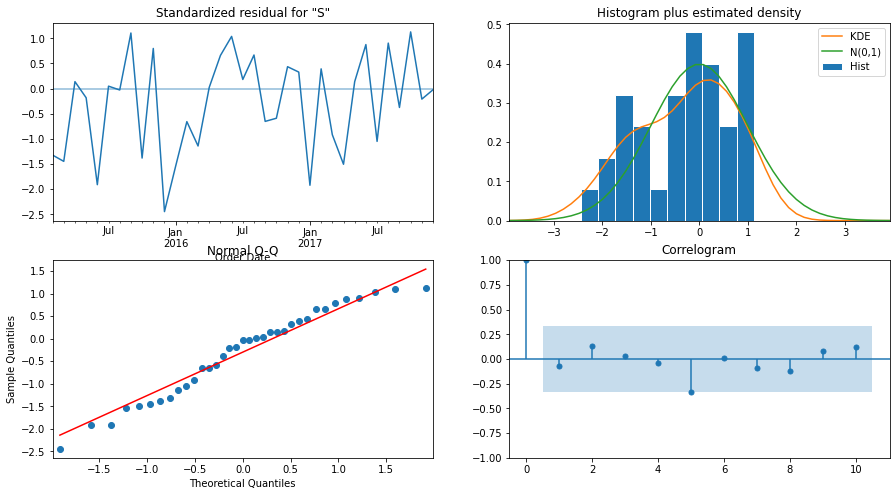

In [21]:
results.plot_diagnostics(figsize=(15, 8))
plt.show()

The above plots suggest that the Model Residuals are nearly Normally Distributed.

## Validating the model forecasts

            lower Sales  upper Sales
Order Date                          
2017-01-01   389.646986  1208.010188
2017-02-01    38.031066   855.042124
2017-03-01   327.688589  1143.492561
2017-04-01   358.593426  1173.313213
2017-05-01   242.636931  1056.377570
2017-06-01   238.706978  1051.558947
2017-07-01   373.986939  1186.028726
2017-08-01   265.185581  1076.485714
2017-09-01   881.882324  1692.500990
2017-10-01   237.610722  1047.601065
2017-11-01   916.397118  1725.806301
2017-12-01   856.640839  1665.510904


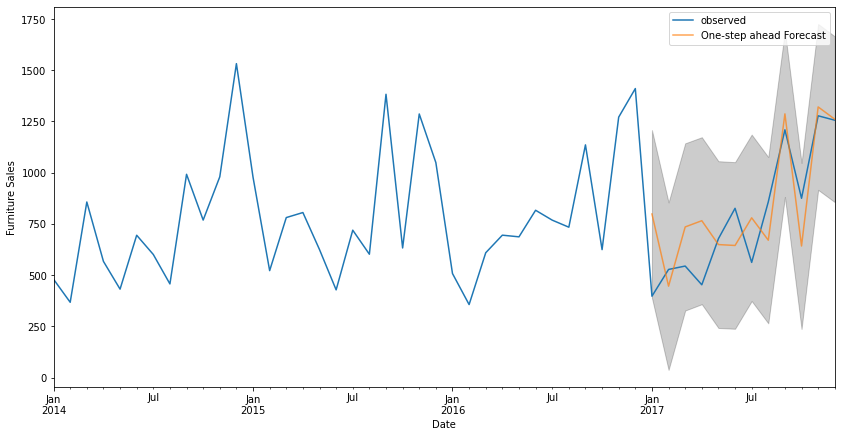

In [22]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
print(pred_ci)
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

The above plot demonstrates that the predicted values alligns well with the true values capturing an upward seasonality. Now, we calculate the Mean Square Error of our predicted values wrt the orignal values.


In [23]:
y_predicted = pred.predicted_mean
y_true = y['2017-01-01':]
mse = ((y_predicted - y_true)**2).mean()
print('Mean Square Error is:', round(mse, 4))
print('Root Mean Square Error is:', np.sqrt(mse))


Mean Square Error is: 39996.0102
Root Mean Square Error is: 199.99002518810065


## Forecasting the future (out of sample) values.

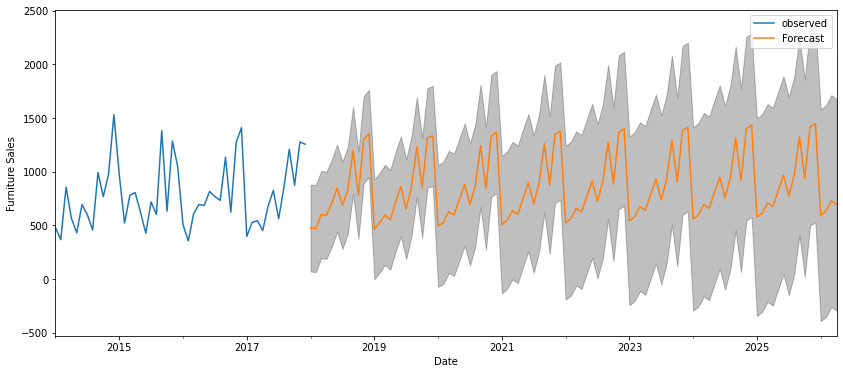

In [24]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()


## Future Forecasts

Here, note that the confidence interval is increasing as we move further into the future. The model becomes less confident in predicting the values as we move ahead.

Our data has 3 categories: 'Furniture', 'Office Supplies' and, 'Technology'. Let's compare the 'Furniture' and 'Office Supplies' time series.

## Furniture vs Office Supplies

In [25]:
furniture = dataset.loc[dataset['Category'] == 'Furniture']
office = dataset.loc[dataset['Category'] == 'Office Supplies']
furniture.shape, office.shape


((2121, 21), (6026, 21))

In [26]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)

furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# Merging both the time series for comparison.

In [27]:
store = furniture.merge(office, on='Order Date', how='inner')
store.rename(columns={'Sales_x': 'Furniture Sales', 'Sales_y': 'Office Sales'}, inplace=True)
store.head()



,Order Date,Furniture Sales,Office Sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


## Visualizing Furniture vs Office Sales time series

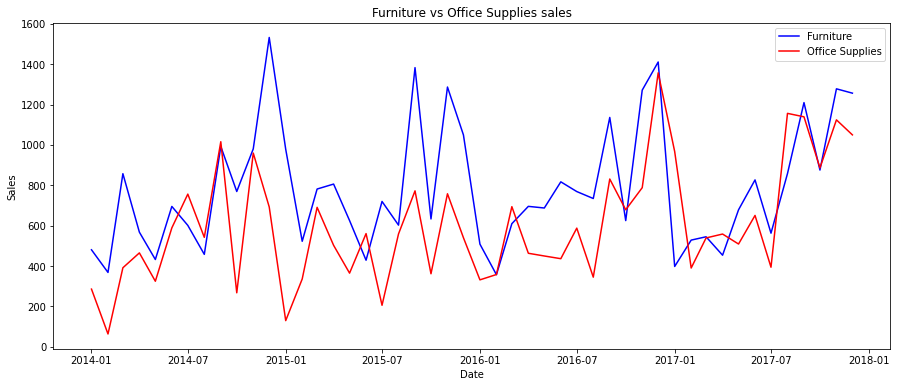

In [29]:
plt.figure(figsize=(15, 6))
plt.plot(store['Order Date'], store['Furniture Sales'], label='Furniture',c='blue')
plt.plot(store['Order Date'], store['Office Sales'], label='Office Supplies',c='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Furniture vs Office Supplies sales')
plt.legend()

The above plot clearly shows that both furniture and office supplies exhibit similar seasonality component.
 The sales are generally low at the beginning of every year as evident from decreasing line slope at the onset of year 2014, 2015, 2016 etc. 
 Also, monthly average sales of furniture is higher than that of office supplies. It's probably because cost of furniture is much more as compared to office utilities.
 But there are few instances in the time series where office supply sales surpass furniture. It is mainly in **July 2014** for the first time in the dataset.


 

## Furniture vs Office Sales vs Technology

In [38]:

technology = dataset.loc[dataset['Category'] == 'Technology']
furniture.shape, office.shape, technology.shape

((48, 2), (48, 2), (1847, 21))

Technology products is having less sales than both furniture and office sales,So we need to merge other products into technologies timeline

In [39]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
technology.drop(cols, axis=1, inplace=True)

technology=technology.sort_values('Order Date')

technology=technology.groupby('Order Date')['Sales'].sum().reset_index()

technology=technology.set_index('Order Date')

y_technology=technology['Sales'].resample('MS').mean()

technology=pd.DataFrame({'Order Date':y_technology.index,'Sales':y_technology.values})


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [40]:
finalstore = technology.merge(store, on='Order Date', how='inner')
finalstore.rename(columns={'Sales': 'Technology Sales'}, inplace=True)
finalstore.head()


,Order Date,Technology Sales,Furniture Sales,Office Sales
0,2014-01-01,449.041429,480.194231,285.357647
1,2014-02-01,229.787143,367.931600,63.042588
2,2014-03-01,2031.948375,857.291529,391.176318
3,2014-04-01,613.028933,567.488357,464.794750
4,2014-05-01,564.698588,432.049188,324.346545


## Visualizing Technology vs Furniture vs Office Sales time series

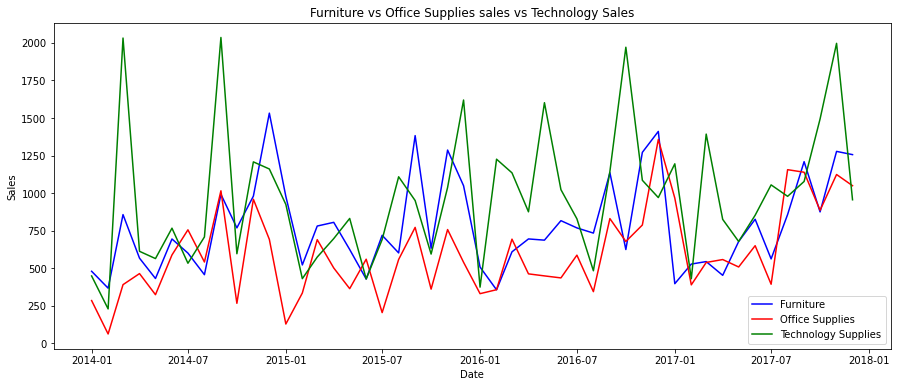

In [42]:
plt.figure(figsize=(15, 6))
plt.plot(finalstore['Order Date'], finalstore['Furniture Sales'], label='Furniture',c='blue')
plt.plot(finalstore['Order Date'], finalstore['Office Sales'], label='Office Supplies',c='red')
plt.plot(finalstore['Order Date'], finalstore['Technology Sales'], label='Technology Supplies',c='green')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Furniture vs Office Supplies sales vs Technology Sales')
plt.legend()